First few rows of the dataset:
         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0  10/03/2004  18.00.00     2.6       1360.0     150.0      11.9   
1  10/03/2004  19.00.00     2.0       1292.0     112.0       9.4   
2  10/03/2004  20.00.00     2.2       1402.0      88.0       9.0   
3  10/03/2004  21.00.00     2.2       1376.0      80.0       9.2   
4  10/03/2004  22.00.00     1.6       1272.0      51.0       6.5   

   PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)  \
0         1046.0    166.0        1056.0    113.0        1692.0       1268.0   
1          955.0    103.0        1174.0     92.0        1559.0        972.0   
2          939.0    131.0        1140.0    114.0        1555.0       1074.0   
3          948.0    172.0        1092.0    122.0        1584.0       1203.0   
4          836.0    131.0        1205.0    116.0        1490.0       1110.0   

      T    RH      AH  Unnamed: 15  Unnamed: 16  
0  13.6  48.9  0.7578          NaN 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


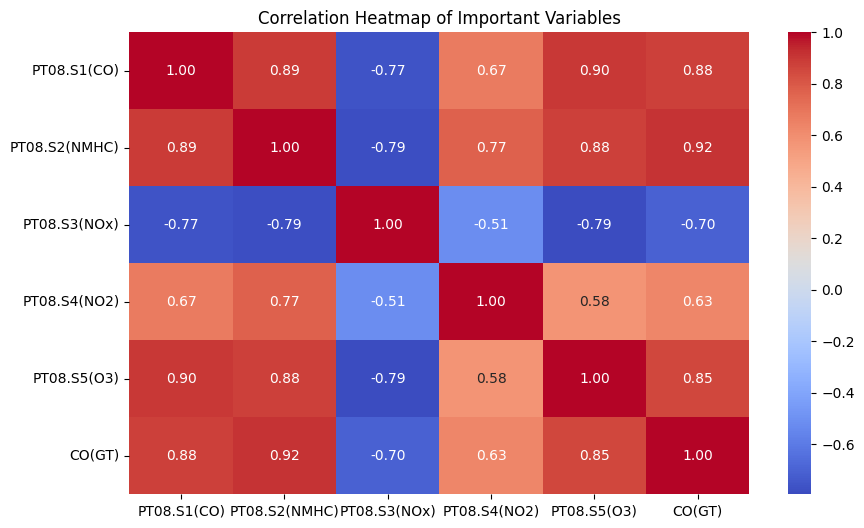

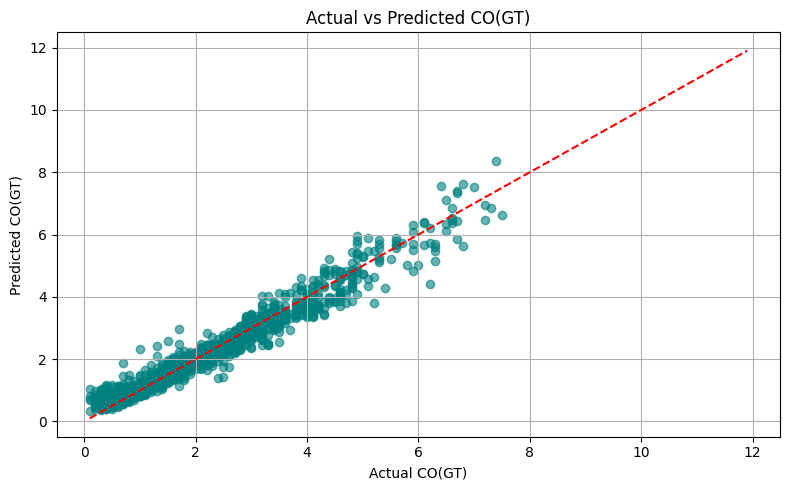

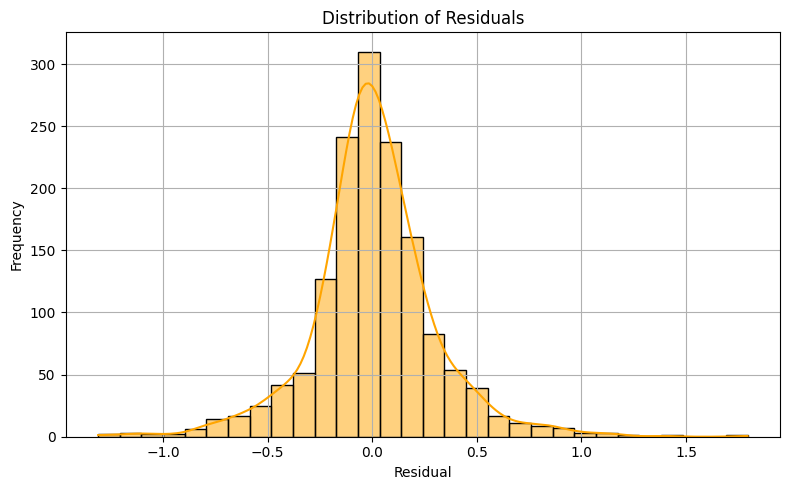

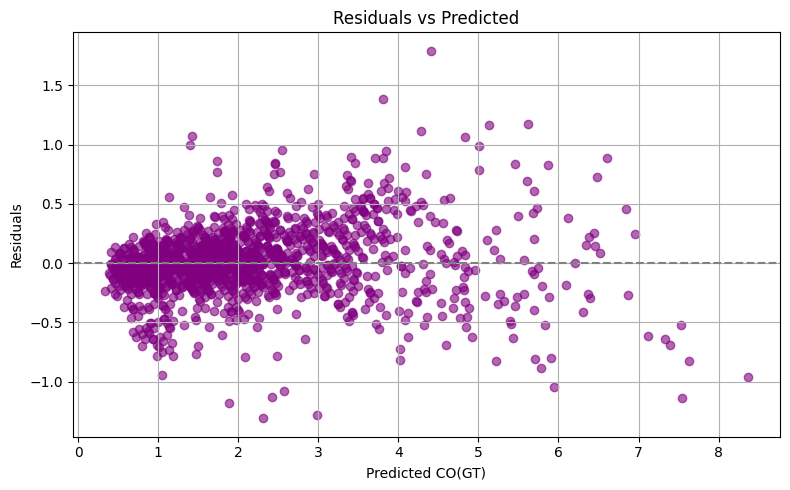

<ipython-input-8-79618d8ea4eb>:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model.coef_, y=X.columns, palette="Reds_d")


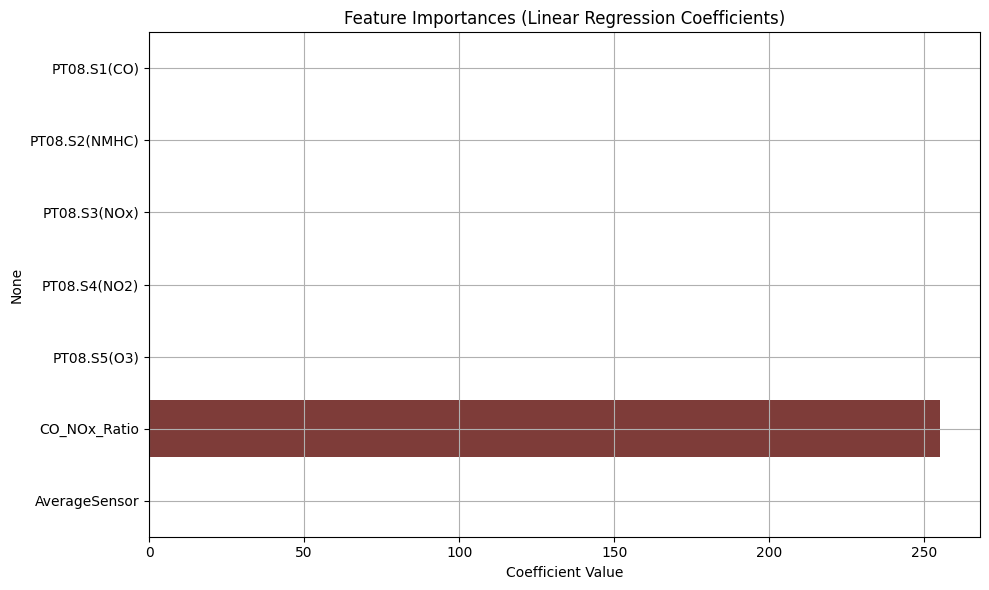

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Load dataset
url = "/content/AirQuality.csv"
df = pd.read_csv(url, sep=";", decimal=",")

# Show raw data
print("First few rows of the dataset:")
print(df.head())

# Replace missing values (-200) with NaN and drop unneeded columns
df = df.replace(-200, np.nan)
df = df.drop(columns=['Unnamed: 15', 'Unnamed: 16'], errors='ignore')

# Important columns to keep
important_cols = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
                  'PT08.S4(NO2)', 'PT08.S5(O3)', 'CO(GT)']
df = df.dropna(subset=important_cols)

# Additional features (optional)
df['CO_NOx_Ratio'] = df['CO(GT)'] / (df['PT08.S3(NOx)'] + 1)  # Avoid div by zero
df['AverageSensor'] = df[['PT08.S1(CO)', 'PT08.S2(NMHC)',
                          'PT08.S3(NOx)', 'PT08.S4(NO2)',
                          'PT08.S5(O3)']].mean(axis=1)

print("✅ Cleaned data shape:", df.shape)
print("\nColumns after processing:")
print(df.columns)

# Feature set and target
X = df[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
        'PT08.S4(NO2)', 'PT08.S5(O3)', 'CO_NOx_Ratio', 'AverageSensor']]
y = df['CO(GT)']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy_like = model.score(X_test, y_test) * 100

print("\nPredicted values vs True values (first 5):")
for i in range(5):
    print(f"True: {y_test.values[i]:.2f} | Predicted: {y_pred[i]:.2f}")

print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Accuracy-like Score: {accuracy_like:.2f}%")

# Save model
joblib.dump(model, 'air_quality_model.pkl')

# Reload model
model = joblib.load('air_quality_model.pkl')

# Predict on new data
future_data = np.array([[1500, 1000, 1100, 1500, 1300, 0.002, 1280]])  # Sample input
predicted_co = model.predict(future_data)
print(f"\nPredicted CO concentration for new data: {predicted_co[0]:.2f}")

# =======================
# 📊 VISUALIZATIONS BELOW
# =======================

# 1. Correlation Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df[important_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Important Variables")
plt.show()

# 2. Actual vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='teal', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual CO(GT)")
plt.ylabel("Predicted CO(GT)")
plt.title("Actual vs Predicted CO(GT)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Residuals Distribution
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Residuals vs Predictions
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, color='purple', alpha=0.6)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel("Predicted CO(GT)")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Feature Coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=model.coef_, y=X.columns, palette="Reds_d")
plt.title("Feature Importances (Linear Regression Coefficients)")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.grid(True)
plt.show()


